In [1]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
from torch.utils.data import DataLoader, Dataset
from torch import cuda
import math
import torch.optim.lr_scheduler as sched

import matplotlib.pyplot as plt
%matplotlib inline

import imageio

In [16]:
def make_train_gif(min_val, max_val, Z, predictions, samples_rmse):
    plt.cla()
    ax.set_title('Regression Analysis - Batches', fontsize=35)
    ax.set_xlabel('Independent variable', fontsize=24)
    ax.set_ylabel('Dependent variable', fontsize=24)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.scatter(Z.numpy(), Z.numpy(), color = "blue", alpha=0.3)
    ax.scatter(Z.numpy(), predictions.numpy(), color='green', alpha=0.3)
    ax.text(0.8*max_val, 1.2*min_val, 'Epoch = %d' % epoch,
            fontdict={'size': 24, 'color':  'red'})
    ax.text(0.8*max_val, 1.5*min_val, 'Loss = %.4f' % samples_rmse,
            fontdict={'size': 24, 'color':  'red'})

    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    my_images.append(image)      


In [17]:
class DatasetUnknownFunc(Dataset):
    def __init__(self, min_val = 1000, max_val = 2000):
        xy = np.mgrid[min_val:max_val, min_val:max_val].reshape(2, -1)
        self.data = pd.DataFrame({'X' : xy[0], 'Y' : xy[1]})
        #self.data['Z'] = (self.data['X'] != self.data['Y']).astype('float')
        self.data['Z'] = self.data['X'] + self.data['Y']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return {
          'X': torch.tensor(self.data.X[index], dtype=torch.float),
          'Y': torch.tensor(self.data.Y[index], dtype=torch.float),
          'Z': torch.tensor(self.data.Z[index], dtype=torch.float),
          'xy' : torch.tensor([self.data.X[index], self.data.Y[index]], dtype=torch.float)
      } 

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, type = 2):
        super(Net, self).__init__()
        self.type = type
        if type == 1:
          self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
          self.relu = torch.nn.ReLU()
          self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        elif type == 2:
          self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
          self.relu = torch.nn.LeakyReLU()
          self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer
        else:
          self.hidden = torch.nn.Linear(n_feature, n_hidden)
          self.relu = torch.nn.LeakyReLU()
          self.hidden1 = torch.nn.Linear(n_hidden, 100)
          self.relu1 = torch.nn.LeakyReLU(),
          self.predict = torch.nn.Linear(100, n_output)

    def forward(self, xy):
      if self.type == 1:
        xy = self.hidden(xy)
        xy = self.relu(xy)
        z = self.predict(xy)
      elif self.type == 2:
        xy = self.hidden(xy)
        xy = self.relu(xy)
        z = self.predict(xy)
      else:
        xy = self.hidden(xy)
        xy = self.relu(xy)
        xy = self.hidden1(xy)
        xy = self.relu1(xy)
        z = self.predict(xy)

      return z


def rmspe_func(y_pred, y_true):
    error = 0
    for val1, val2 in zip(y_pred.cpu().numpy(), y_true.cpu().numpy()):
        error += (val2 - val1)*(val2 - val1)
    return error

In [18]:
device = 'cuda' if cuda.is_available() else 'cpu'

BATCH_SIZE = 20
EPOCH = 8
min_val = 100
max_val = 200

model = Net(n_feature=2, n_hidden=10, n_output=1, type = 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

scheduler = None

loss_function = torch.nn.MSELoss()

train_dataset = DatasetUnknownFunc(min_val = min_val, max_val = max_val)
training_loader = Data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2)

Training RMSE Epoch(0): 654335316.8970957
Training RMSE Epoch(1): 41.0731858004328
Training RMSE Epoch(2): 41.035626075665945
Training RMSE Epoch(3): 41.11278076447153
Training RMSE Epoch(4): 41.09511642214924
Training RMSE Epoch(5): 41.07467772716695
Training RMSE Epoch(6): 41.093785646372375
Training RMSE Epoch(7): 41.114744815101766


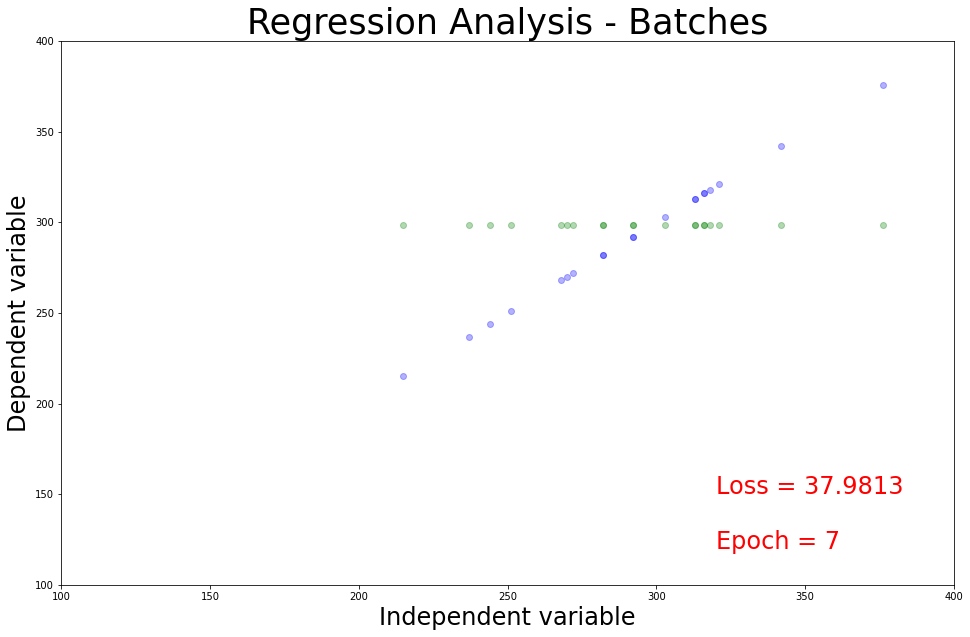

In [19]:
make_gif = True

if make_gif == True:
  my_images = []
  fig, ax = plt.subplots(figsize=(16,10))

model.train()
for epoch in range(EPOCH):
  rmse = 0
  nb_tr_examples = 0

  for step ,data in enumerate(training_loader, 0):
      xy = data['xy'].to(device, dtype = torch.float)
      Z = data['Z'].to(device, dtype = torch.float)
      outputs = model(xy)

      loss = loss_function(outputs.view(-1), Z.view(-1))
      rmse += rmspe_func(outputs.data, Z)
      nb_tr_examples+=xy.size(0)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if scheduler != None:
        scheduler.step()

      samples_rmse = math.sqrt(rmse/nb_tr_examples)
      if (nb_tr_examples % 1000000 == 0):
        print(f"Training RMSE num trained samples: ({nb_tr_examples}): {samples_rmse}")

      if (make_gif == True) & (step == 0):
        make_train_gif(min_val, 2*max_val, Z, outputs.data, samples_rmse)

  epoch_rmse = math.sqrt(rmse/nb_tr_examples)
  print(f"Training RMSE Epoch({epoch}): {epoch_rmse}")

  if make_gif == True:
    imageio.mimsave('./curve_model_batch.gif', my_images, fps=12)

In [20]:
testing_loader = DatasetUnknownFunc(min_val = 1, max_val = 10)
testing_loader = Data.DataLoader(
    dataset=testing_loader, 
    batch_size=10, 
    shuffle=False, num_workers=2)

rmse = 0; nb_tr_examples = 0;

with torch.no_grad():
  model.eval()
  for _, data in enumerate(testing_loader, 0):
    xy = data['xy'].to(device, dtype = torch.float)
    outputs = model(xy)
            
    rmse += rmspe_func(outputs.data, Z)
    nb_tr_examples+=xy.size(0)
        
  rmse = math.sqrt(rmse/nb_tr_examples)
    
print(f"Validation RMSE: {rmse}\n")

Validation RMSE: 43.250407839930396

